# Optimal threshholds 탐색
<img src = 'https://c1.staticflickr.com/5/4340/37157583241_7cc603070c_z_d.jpg'>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
# Imports
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family']='Malgun Gothic'

In [2]:
data = pd.read_pickle('../../pkl/df_filtered-01.pkl')
data.head()

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
2225054,즉석조리식품,판매용,인도네시아,3.647,아니오,아니오,아니오,표시함,N,N,N,0,6.546785,7.839526
255568,배추김치,판매용,중국,0.460,아니오,아니오,아니오,해당없음,N,N,N,0,8.987322,8.210940
130945,과실주,판매용,호주,11.692,아니오,아니오,아니오,해당없음,N,N,N,0,6.916715,9.374673
2089969,기타 수산물가공품,판매용,베트남,5.400,아니오,아니오,아니오,표시함,N,N,N,0,9.287394,10.973718
193189,과실주,판매용,프랑스,2.333,아니오,아니오,아니오,해당없음,N,N,N,0,8.412055,9.259226


## 1. 데이터 전처리

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

numeric_features = data.drop(['판정결과'], axis=1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.drop(['판정결과'], axis=1).select_dtypes(include=['object', 'category']).columns

X = data.drop('판정결과', axis=1)
y = data['판정결과']

le = preprocessing.LabelEncoder()
label_encoder = le.fit(y)
y = label_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [5]:
import category_encoders as ce

## 2. 예측

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, average_precision_score
from sklearn.metrics import log_loss, brier_score_loss, matthews_corrcoef
from sklearn.model_selection import KFold, RandomizedSearchCV

In [7]:
classifiers = {}
classifiers.update({'LGR': LogisticRegression(class_weight='balanced')})
classifiers.update({'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=500)})
classifiers.update({'KNN': KNeighborsClassifier()}) # class weight option이 없음

In [8]:
parameters = {}

parameters.update({'LGR': 
{ 
'classifier__C': [0.01, 0.1, 1, 10], 'classifier__penalty': ['l1', 'l2']}
})

parameters.update({'Random Forest': 
{ 
'classifier__n_estimators':  [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [int(x) for x in np.linspace(5, 20, 10)],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
'classifier__criterion' :['gini', 'entropy']     ,
'classifier__bootstrap': [True, False]
}})

parameters.update({'KNN': 
{ 
#'classifier__n_neighbors':  [int(x) for x in np.linspace(start = 3, stop = 100, num = 5)],
#'classifier__weights': ['uniform','distance'],
#'classifier__leaf_size': list(range(4,30))
}})

In [9]:
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold
kf = KFold(n_splits=5)
skf = StratifiedKFold(n_splits=5)

for classifier_label, classifier in tqdm_notebook(classifiers.items()):

    param_grid = parameters[classifier_label]
    #param_grid = {}

    print(classifier)
    numeric_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('catencoder', ce.woe.WOEEncoder())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)])

    grid_search = RandomizedSearchCV(pipe, 
                                     param_grid, 
                                     cv = skf,  
                                     n_jobs= -1,
                                     scoring= 'recall',
                                     ) 

    model = grid_search.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    print('*'*70)

LogisticRegression(class_weight='balanced')
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     72494
           1       0.03      0.80      0.06       783

    accuracy                           0.73     73277
   macro avg       0.51      0.76      0.45     73277
weighted avg       0.99      0.73      0.83     73277

**********************************************************************
RandomForestClassifier(class_weight='balanced', n_estimators=500)
              precision    recall  f1-score   support

           0       1.00      0.63      0.77     72494
           1       0.02      0.86      0.05       783

    accuracy                           0.63     73277
   macro avg       0.51      0.75      0.41     73277
weighted avg       0.99      0.63      0.77     73277

**********************************************************************
KNeighborsClassifier()
              precision    recall  f1-score   support

           0    

## 방안 1: 예측 모형의 성능지표를 변경

In [10]:
from sklearn.metrics import make_scorer, precision_score, confusion_matrix

In [11]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(f1_score)
}

In [12]:
classifiers.keys()
parameters.keys()

dict_keys(['LGR', 'Random Forest', 'KNN'])

dict_keys(['LGR', 'Random Forest', 'KNN'])

In [13]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=3)
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifiers['Random Forest'])])
        
    grid_search = RandomizedSearchCV(pipe, 
                                     parameters['Random Forest'], 
                                     scoring=scorers, 
                                     refit = refit_score,
                                     cv = skf, 
                                     return_train_score=True, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    print(classification_report(y_test, y_pred))
    
    return grid_search

In [14]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'classifier__n_estimators': 20, 'classifier__min_samples_split': 0.05, 'classifier__min_samples_leaf': 0.005, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 11, 'classifier__criterion': 'entropy', 'classifier__class_weight': 'balanced', 'classifier__bootstrap': True}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg     51474     21020
pos       139       644
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     72494
           1       0.03      0.82      0.06       783

    accuracy                           0.71     73277
   macro avg       0.51      0.77      0.44     73277
weighted avg       0.99      0.71      0.82     73277



In [15]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'classifier__n_estimators': 90, 'classifier__min_samples_split': 0.05, 'classifier__min_samples_leaf': 0.01, 'classifier__max_features': 'log2', 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__class_weight': 'balanced', 'classifier__bootstrap': False}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg     49926     22568
pos       132       651
              precision    recall  f1-score   support

           0       1.00      0.69      0.81     72494
           1       0.03      0.83      0.05       783

    accuracy                           0.69     73277
   macro avg       0.51      0.76      0.43     73277
weighted avg       0.99      0.69      0.81     73277



## Check ROC, PR curve

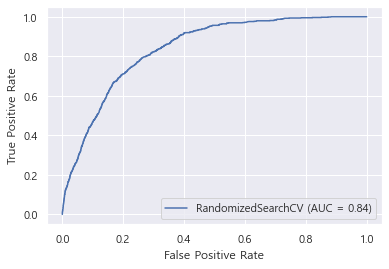

In [16]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(grid_search_clf, X_test, y_test)  
plt.show()

In [17]:
from sklearn.metrics import roc_auc_score
y_score = grid_search_clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_score)

0.8391547778067756

In [18]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.06


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.06')

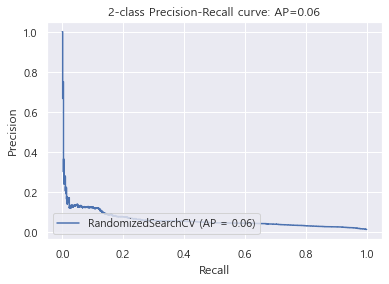

In [19]:
from sklearn.metrics import plot_precision_recall_curve
disp = plot_precision_recall_curve(grid_search_clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: ' 'AP={0:0.2f}'.format(average_precision))

In [20]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_features,param_classifier__max_depth,param_classifier__criterion,...,split1_test_accuracy_score,split2_test_accuracy_score,mean_test_accuracy_score,std_test_accuracy_score,rank_test_accuracy_score,split0_train_accuracy_score,split1_train_accuracy_score,split2_train_accuracy_score,mean_train_accuracy_score,std_train_accuracy_score
1,20.902252,1.270707,1.314293,0.203729,40,0.005,0.01,auto,13,gini,...,0.054387,0.059041,0.057525,0.002219,1,0.060796,0.056462,0.062396,0.059885,0.002507
5,52.792954,1.775235,1.648950,0.402387,90,0.05,0.01,log2,5,gini,...,0.052542,0.053379,0.053624,0.000999,2,0.056162,0.054571,0.055647,0.055460,0.000663
0,33.211492,4.223556,1.921370,0.338796,80,0.1,0.05,sqrt,13,gini,...,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000
2,48.465168,1.185089,2.042793,0.234189,80,0.1,0.005,auto,11,entropy,...,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000
3,26.693441,0.906542,1.729468,0.057064,80,0.1,0.05,log2,18,gini,...,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000
4,50.421716,1.111331,2.032563,0.118814,80,0.05,0.01,log2,10,entropy,...,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000
6,37.611837,3.087893,2.276243,0.117263,90,0.005,0.01,log2,5,gini,...,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000
7,18.732108,0.872363,1.873652,0.162322,50,0.1,0.1,auto,10,gini,...,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000
8,16.926345,0.917747,0.884730,0.015480,80,0.05,0.05,log2,20,gini,...,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000
9,21.305811,0.509748,0.684423,0.022717,80,0.005,0.01,sqrt,6,entropy,...,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000


## 방안 2: 최적의 의사결정임계값(threshold value)를 탐색

In [21]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [22]:
# fit a model

# predict probabilities
yhat = grid_search_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold
from sklearn.metrics import f1_score
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-measure=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.760, F-measure=0.11801


In [23]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_test, probs)
pd.DataFrame(np.vstack([p, r]), index=['정밀도', '재현율']).round(2)
pd.DataFrame(thresholds,columns=['분류임계값']).T.round(2)

,0,1,2,3,4,5,6,7,8,9,...,30837,30838,30839,30840,30841,30842,30843,30844,30845,30846
정밀도,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.27,0.36,0.3,0.38,0.43,0.6,0.75,0.67,1.0,1.0
재현율,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.01,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,30836,30837,30838,30839,30840,30841,30842,30843,30844,30845
분류임계값,0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.81


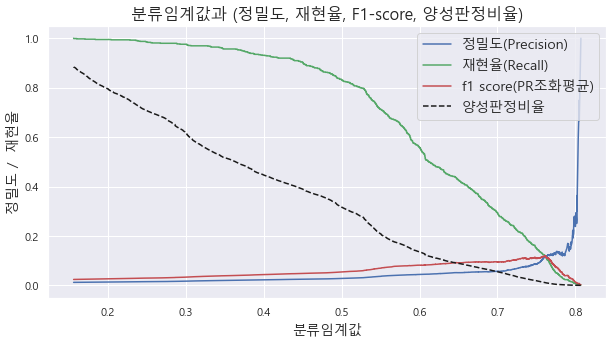

In [24]:
scores = [np.sum(to_labels(probs, t))/len(probs) for t in thresholds]
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.rcParams["figure.figsize"] = (10,5)
    plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
    plt.title('분류임계값과 (정밀도, 재현율, F1-score, 양성판정비율)', fontsize='16') 
    plt.plot(thresholds, precisions[:-1], 'b-', label='정밀도(Precision)') # 판사
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율(Recall)') # 검사
    plt.plot(thresholds, (2*precisions[:-1]*recalls[:-1])/(precisions[:-1] +recalls[:-1]), 
             'r-', label='f1 score(PR조화평균)') # 변호사
    plt.plot(thresholds, scores, 'k--', label='양성판정비율') # q-ratio
    plt.ylabel('정밀도 /  재현율', fontsize='14') 
    plt.xlabel('분류임계값', fontsize='14') 
    plt.legend(loc='best', fontsize='14') 
    
plot_precision_recall_vs_threshold(p, r, thresholds)

## 방안 3: 다양한 metrics로 Tuning

In [25]:
from sklearn.metrics import fbeta_score
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [26]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=3)
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifiers['Random Forest'])])
        
    grid_search = RandomizedSearchCV(pipe, 
                                     parameters['Random Forest'], 
                                     scoring=ftwo_scorer, 
                                     refit = refit_score,
                                     cv = skf, 
                                     return_train_score=True, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    print(classification_report(y_test, y_pred))
    
    return grid_search

In [27]:
grid_search_clf = grid_search_wrapper(refit_score='ftwo_scorer')

Best params for ftwo_scorer
{'classifier__n_estimators': 70, 'classifier__min_samples_split': 0.1, 'classifier__min_samples_leaf': 0.005, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 15, 'classifier__criterion': 'entropy', 'classifier__class_weight': 'balanced', 'classifier__bootstrap': False}

Confusion matrix of Random Forest optimized for ftwo_scorer on the test data:
     pred_neg  pred_pos
neg     51236     21258
pos       142       641
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     72494
           1       0.03      0.82      0.06       783

    accuracy                           0.71     73277
   macro avg       0.51      0.76      0.44     73277
weighted avg       0.99      0.71      0.82     73277



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.06')

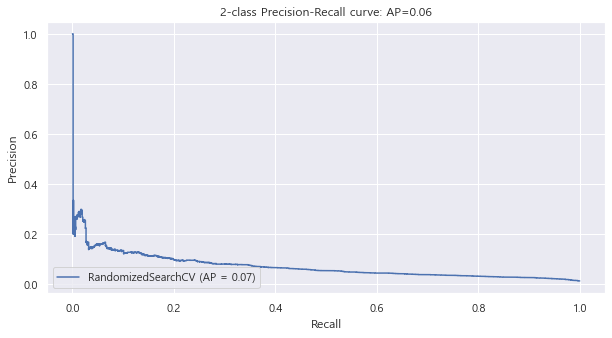

In [28]:
disp = plot_precision_recall_curve(grid_search_clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: ' 'AP={0:0.2f}'.format(average_precision))

In [29]:
from sklearn.metrics import brier_score_loss
brier_score_loss(y_test, y_score)

0.17901176990819384

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

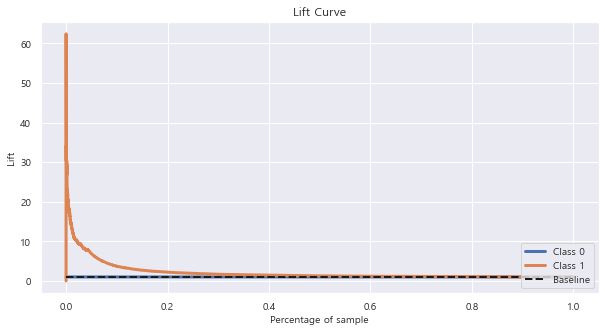

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

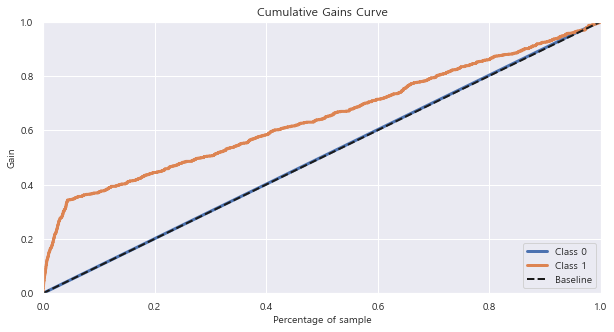

In [30]:
import scikitplot as skplt 
y_probas = grid_search.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test, y_probas); plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

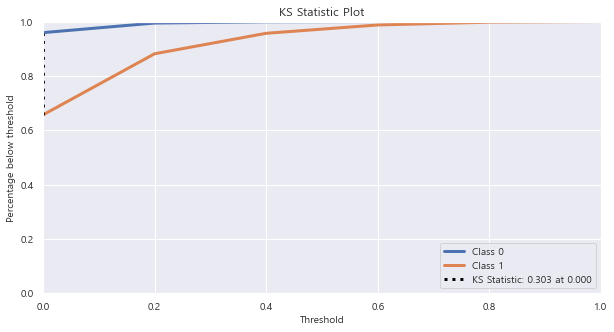

In [31]:
skplt.metrics.plot_ks_statistic(y_test, y_probas)

In [32]:
from sklearn.metrics import log_loss
log_loss(y_test, y_probas)

0.2592873328350485

In [33]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

0.10788387018926704

In [34]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_pred)

0.07277375795598495

# End